In [10]:
## Import des librairies et warnings
import pandas as pd
import numpy as np
import warnings
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")  # Supprime warnings sklearn, xgboost, lightgbm


In [12]:
## Chargement des données
df = pd.read_csv("dataset_export_1h_4h_1d.csv")
print(df.head())
interval_mapping = {2: 60, 3: 240, 4: 1440}  # minutes
symbol_mapping = {1: "BTCUSDT", 2: "ETHUSDT", 3: "BNBUSDT", 4: "SOLUSDT"}

df["interval_min"] = df["interval_id"].map(interval_mapping)
df["symbol_label"] = df["symbol_id"].map(symbol_mapping)


   klines_id  symbol_id  interval_id            open_time  \
0          1          3            4  2023-01-30 00:00:00   
1          2          3            4  2023-01-31 00:00:00   
2          3          3            4  2023-02-01 00:00:00   
3          4          3            4  2023-02-02 00:00:00   
4          5          3            4  2023-02-03 00:00:00   

                close_time   open   high    low  close      volume  \
0  2023-01-30 23:59:59.999  317.1  320.8  302.0  307.2  413716.212   
1  2023-01-31 23:59:59.999  307.2  314.4  305.3  312.0  278061.958   
2  2023-02-01 23:59:59.999  312.1  319.4  305.6  317.0  390978.523   
3  2023-02-02 23:59:59.999  317.1  334.4  316.3  323.5  587655.881   
4  2023-02-03 23:59:59.999  323.5  335.5  318.3  332.2  579577.162   

                   created_at  
0  2025-10-30 14:46:00.254029  
1  2025-10-30 14:46:00.254029  
2  2025-10-30 14:46:00.254029  
3  2025-10-30 14:46:00.254029  
4  2025-10-30 14:46:00.254029  


In [13]:
## Paramètres et création de la target
horizon = 10           # horizon de prédiction
threshold = 0.01       # seuil de variation pour target binaire

df["future_return"] = df["close"].shift(-horizon) / df["close"] - 1
df["target"] = np.where(df["future_return"] > threshold, 1,
                        np.where(df["future_return"] < -threshold, 0, np.nan))
df.dropna(subset=["target"], inplace=True)


In [14]:
## définition des indicateurs techniques
def compute_RSI(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_indicators(df):
    df = df.copy()
    df["RSI"] = compute_RSI(df["close"])
    df["MA_10"] = df["close"].rolling(10).mean()
    df["MA_50"] = df["close"].rolling(50).mean()
    df["STD_20"] = df["close"].rolling(20).std()
    df["RET"] = df["close"].pct_change()
    df["VOLAT"] = df["RET"].rolling(10).std()
    for lag in [1,2,3]:
        df[f"close_lag{lag}"] = df["close"].shift(lag)
        df[f"volume_lag{lag}"] = df["volume"].shift(lag)
    df.dropna(inplace=True)
    return df


In [24]:
## Boucle sur les symboles
results = {}
symbols = df["symbol_label"].unique()

for symbol in symbols:
    data = df[df["symbol_label"] == symbol].copy()
    if len(data) < 300:
        continue

    print(f"\n=== {symbol} ===")

    # Train/test split avant feature engineering pour éviter leakage
    raw_features = data[["open","high","low","close","volume"]].copy()
    raw_target = data["target"]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        raw_features, raw_target, test_size=0.3, shuffle=False
    )

    # Calcul des features
    train_data = X_train_raw.copy()
    train_data["target"] = y_train
    train_data = compute_indicators(train_data)
    X_train = train_data.drop(columns=["target"])
    y_train = train_data["target"]

    test_data = X_test_raw.copy()
    test_data["target"] = y_test
    test_data = compute_indicators(test_data)
    X_test = test_data.drop(columns=["target"])
    y_test = test_data["target"]

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Gestion déséquilibre
    classes = np.unique(y_train)
    class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
    weight_dict = dict(zip(classes, class_weights))
    scale_pos_weight = weight_dict[0] / weight_dict[1]

     ## Définition et entraînement des modèles de base
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "RandomForest": RandomForestClassifier(n_estimators=150, max_depth=6, max_features="sqrt",
                                           random_state=42, class_weight="balanced"),
        "XGBoost": XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05,
                             subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
                             use_label_encoder=False, random_state=42, scale_pos_weight=scale_pos_weight, verbosity=0),
        "LightGBM": LGBMClassifier(num_leaves=31, max_depth=5, learning_rate=0.05,
                               n_estimators=200, subsample=0.8, colsample_bytree=0.8,
                               scale_pos_weight=scale_pos_weight, random_state=42, verbosity=-1)
    }

    scores = {}

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        scores[name+"_BASE"] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        print(f"[BASE] {name:12s} | Acc: {scores[name+'_BASE']['accuracy']:.3f} | F1: {scores[name+'_BASE']['f1']:.3f}")
        
    ## Optimisation des hyperparamètres
    param_rf = {"n_estimators":[100,200,300], "max_depth":[3,5,6,8], "min_samples_split":[2,5], "max_features":["sqrt","log2"]}
    param_xgb = {"n_estimators":[100,200], "max_depth":[3,4,5], "learning_rate":[0.01,0.05], "subsample":[0.7,0.8], "colsample_bytree":[0.7,0.8], "scale_pos_weight":[scale_pos_weight]}
    param_lgb = {"num_leaves":[15,31], "max_depth":[3,5], "learning_rate":[0.01,0.05], "n_estimators":[100,200], "subsample":[0.7,0.8], "colsample_bytree":[0.7,0.8], "scale_pos_weight":[scale_pos_weight]}

    tuned_models = {
        "RandomForest_OPT": (RandomForestClassifier(random_state=42, class_weight="balanced"), param_rf),
        "XGBoost_OPT": (XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42), param_xgb),
        "LightGBM_OPT": (LGBMClassifier(random_state=42, verbosity=-1), param_lgb)
    }

    for name, (model, param_grid) in tuned_models.items():
        search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, scoring="f1", n_jobs=-1, random_state=42)
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        scores[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        print(f"[OPT] {name:12s} | Acc: {scores[name]['accuracy']:.3f} | F1: {scores[name]['f1']:.3f}")
        # Sauvegarde modèle optimisé
        joblib.dump(best_model, f"{symbol}_{name}.pkl")

    ## Résultat final
    best_model_name = max(scores, key=lambda x: scores[x]["f1"])
    results[symbol] = {**scores[best_model_name], "best_model": best_model_name}
print("\n=== Résumé global ===")
for sym, res in results.items():
    print(f"{sym:10s} → {res['best_model']:18s} | Acc {res['accuracy']:.3f} | F1 {res['f1']:.3f}")


=== BNBUSDT ===
[BASE] LogisticRegression | Acc: 0.543 | F1: 0.651
[BASE] RandomForest | Acc: 0.533 | F1: 0.631
[BASE] XGBoost      | Acc: 0.560 | F1: 0.684
[BASE] LightGBM     | Acc: 0.563 | F1: 0.670
[OPT] RandomForest_OPT | Acc: 0.524 | F1: 0.620
[OPT] XGBoost_OPT  | Acc: 0.530 | F1: 0.692
[OPT] LightGBM_OPT | Acc: 0.532 | F1: 0.692

=== ETHUSDT ===
[BASE] LogisticRegression | Acc: 0.538 | F1: 0.632
[BASE] RandomForest | Acc: 0.560 | F1: 0.635
[BASE] XGBoost      | Acc: 0.560 | F1: 0.660
[BASE] LightGBM     | Acc: 0.547 | F1: 0.632
[OPT] RandomForest_OPT | Acc: 0.558 | F1: 0.632
[OPT] XGBoost_OPT  | Acc: 0.525 | F1: 0.684
[OPT] LightGBM_OPT | Acc: 0.528 | F1: 0.684

=== BTCUSDT ===
[BASE] LogisticRegression | Acc: 0.489 | F1: 0.653
[BASE] RandomForest | Acc: 0.512 | F1: 0.637
[BASE] XGBoost      | Acc: 0.502 | F1: 0.644
[BASE] LightGBM     | Acc: 0.493 | F1: 0.631
[OPT] RandomForest_OPT | Acc: 0.501 | F1: 0.657
[OPT] XGBoost_OPT  | Acc: 0.488 | F1: 0.656
[OPT] LightGBM_OPT | Acc: 0

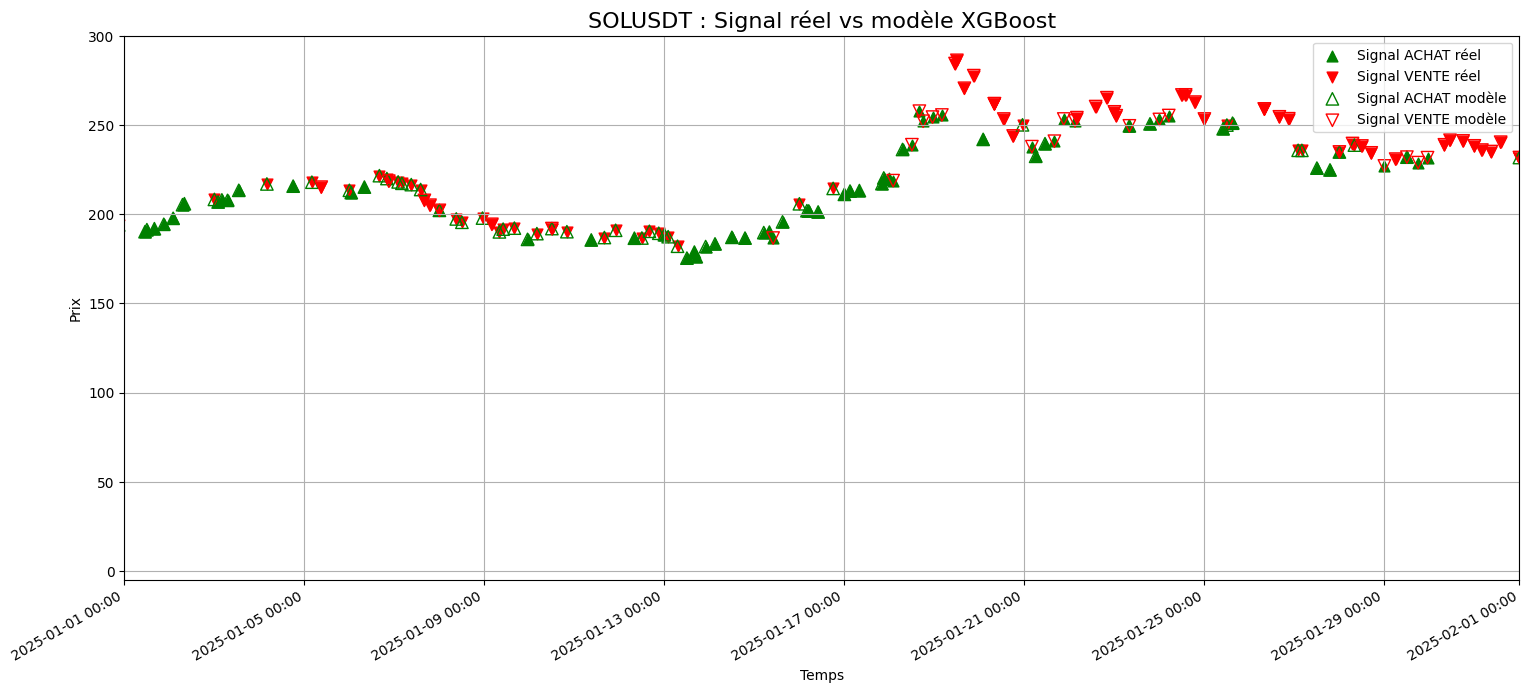

In [26]:
## Visualisation graphique des prix réels/modélisés (XG Boost) par symbol en fonction du temps 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

# ===========================
# Paramètres
# ===========================
symbols = ["SOLUSDT"]  # Choisir le symbole à visualiser
model_folder = "."
dataset_file = "dataset_export_1h_4h_1d.csv"
horizon = 10
threshold = 0.01
sample_step = 5  # Échantillonnage pour réduire la densité

# Limites axe des abscisses (changer si besoin)
start_date = "2025-01-01 00:00"
end_date = "2025-02-01 00:00"

# ===========================
# Chargement dataset
# ===========================
df = pd.read_csv(dataset_file)
symbol_mapping = {1: "BTCUSDT", 2: "ETHUSDT", 3: "BNBUSDT", 4: "SOLUSDT"}
df["symbol_label"] = df["symbol_id"].map(symbol_mapping)
data = df[df["symbol_label"] == symbols[0]].copy()

# Target
data["future_return"] = data["close"].shift(-horizon) / data["close"] - 1
data["target"] = np.where(data["future_return"] > threshold, 1,
                          np.where(data["future_return"] < -threshold, 0, np.nan))
data.dropna(subset=["target"], inplace=True)

# Features
def compute_RSI(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_indicators(df):
    df = df.copy()
    df["RSI"] = compute_RSI(df["close"])
    df["MA_10"] = df["close"].rolling(10).mean()
    df["MA_50"] = df["close"].rolling(50).mean()
    df["STD_20"] = df["close"].rolling(20).std()
    df["RET"] = df["close"].pct_change()
    df["VOLAT"] = df["RET"].rolling(10).std()
    for lag in [1,2,3]:
        df[f"close_lag{lag}"] = df["close"].shift(lag)
        df[f"volume_lag{lag}"] = df["volume"].shift(lag)
    df.dropna(inplace=True)
    return df

data_feat = compute_indicators(data)
features = ["open","high","low","close","volume","RSI","MA_10","MA_50","STD_20","RET","VOLAT",
            "close_lag1","close_lag2","close_lag3","volume_lag1","volume_lag2","volume_lag3"]
X = data_feat[features]
y = data_feat["target"]

# Normalisation et modèle
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model_file = f"{model_folder}/{symbols[0]}_XGBoost_OPT.pkl"
model = joblib.load(model_file)
data_feat["prediction"] = model.predict(X_scaled)

# Conversion datetime et échantillonnage
data_feat["datetime"] = pd.to_datetime(data_feat["close_time"])
df_plot = data_feat.iloc[::sample_step]

# ===========================
# Visualisation
# ===========================
plt.figure(figsize=(18,8))

# Signal réel
buy_idx = df_plot[df_plot["target"] == 1].index
sell_idx = df_plot[df_plot["target"] == 0].index
plt.scatter(df_plot.loc[buy_idx, "datetime"], df_plot.loc[buy_idx, "close"],
            label="Signal ACHAT réel", marker="^", s=60, color="green")
plt.scatter(df_plot.loc[sell_idx, "datetime"], df_plot.loc[sell_idx, "close"],
            label="Signal VENTE réel", marker="v", s=60, color="red")

# Signal modèle
buy_pred = df_plot[df_plot["prediction"] == 1].index
sell_pred = df_plot[df_plot["prediction"] == 0].index
plt.scatter(df_plot.loc[buy_pred, "datetime"], df_plot.loc[buy_pred, "close"],
            label="Signal ACHAT modèle", marker="^", s=80, facecolors='none', edgecolors='green')
plt.scatter(df_plot.loc[sell_pred, "datetime"], df_plot.loc[sell_pred, "close"],
            label="Signal VENTE modèle", marker="v", s=80, facecolors='none', edgecolors='red')

# Limites axe des abscisses
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Axe date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gcf().autofmt_xdate()
plt.title(f"{symbols[0]} : Signal réel vs modèle XGBoost", fontsize=16)
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()